In [1]:
import pyprob
from pyprob import Model, util
from pyprob.distributions import Categorical, Normal

import torch
import torch.nn.functional as F
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline

# Define model

First, we define the model as a probabilistic program inheriting from `pyprob.Model`. Models inherit from `torch.nn.Module` and can be potentially trained with gradient-based optimization (not covered in this example).

The `forward` function can have any number and type of arguments as needed. 

**Important:** For running posterior inference inference compilation, it is expected that `forward` has an argument called `observation` with which the observations are given to the model.

In [2]:
# http://www.robots.ox.ac.uk/~fwood/assets/pdf/Wood-AISTATS-2014.pdf
class HiddenMarkovModel(Model):
    def __init__(self, init_dist, trans_dists, obs_dists):
        self.init_dist = init_dist
        self.trans_dists = trans_dists
        self.obs_dists = obs_dists
        super().__init__('Hidden Markov model')

    def forward(self, observation=[]):
        states = [pyprob.sample(init_dist)]
        for o in observation:
            state = pyprob.sample(self.trans_dists[int(states[-1])])
            pyprob.observe(self.obs_dists[int(state)], o)
            states.append(state)
        return torch.stack([util.one_hot(3, int(s)) for s in states])

init_dist = Categorical([1, 1, 1])
trans_dists = [Categorical([0.1, 0.5, 0.4]),
               Categorical([0.2, 0.2, 0.6]),
               Categorical([0.15, 0.15, 0.7])]
obs_dists = [Normal(-1, 1),
             Normal(1, 1),
             Normal(0, 1)]
model = HiddenMarkovModel(init_dist, trans_dists, obs_dists)

# Test the prior

We inspect the prior distribution to see if it behaves in the way we intended. First we construct an `Empirical` distribution with forward samples from the model. 

Note: Any arguments, besides `samples`, given to `prior_distribution` will be forwarded to the model's `forward` function.

In [3]:
observation = [0.9, 0.8, 0.7, 0.0, -0.025, -5.0, -2.0, -0.1, 0.0, 0.13, 0.45, 6, 0.2, 0.3, -1, -1]
posterior_mean_correct = util.to_variable([[0.3775, 0.3092, 0.3133],
                                           [0.0416, 0.4045, 0.5539],
                                           [0.0541, 0.2552, 0.6907],
                                           [0.0455, 0.2301, 0.7244],
                                           [0.1062, 0.1217, 0.7721],
                                           [0.0714, 0.1732, 0.7554],
                                           [0.9300, 0.0001, 0.0699],
                                           [0.4577, 0.0452, 0.4971],
                                           [0.0926, 0.2169, 0.6905],
                                           [0.1014, 0.1359, 0.7626],
                                           [0.0985, 0.1575, 0.7440],
                                           [0.1781, 0.2198, 0.6022],
                                           [0.0000, 0.9848, 0.0152],
                                           [0.1130, 0.1674, 0.7195],
                                           [0.0557, 0.1848, 0.7595],
                                           [0.2017, 0.0472, 0.7511],
                                           [0.2545, 0.0611, 0.6844]])
        
prior_dist = model.prior_distribution(traces=1000, observation=observation)

0d:00:00:01 | #################### | 1000 / 1000 | 516 traces/s 


We can see the mean of these samples that are held by the `Empirical` distribution.

In [4]:
prior_dist.mean

Variable containing:
 0.3510  0.3270  0.3220
 0.1240  0.3000  0.5760
 0.1580  0.2060  0.6360
 0.1670  0.2080  0.6250
 0.1430  0.2330  0.6240
 0.1420  0.2220  0.6360
 0.1780  0.2170  0.6050
 0.1440  0.2230  0.6330
 0.1440  0.2230  0.6330
 0.1370  0.2220  0.6410
 0.1330  0.2100  0.6570
 0.1570  0.1890  0.6540
 0.1300  0.2340  0.6360
 0.1580  0.1950  0.6470
 0.1410  0.2210  0.6380
 0.1400  0.2070  0.6530
 0.1240  0.2190  0.6570
[torch.FloatTensor of size 17x3]

We can also `sample` from the `Empirical` distribution.

In [5]:
print(prior_dist.sample())

Variable containing:
    1     0     0
    0     1     0
    0     0     1
    1     0     0
    0     0     1
    0     0     1
    1     0     0
    0     0     1
    0     0     1
    0     1     0
    0     0     1
    0     0     1
    0     0     1
    0     0     1
    0     0     1
    0     0     1
    1     0     0
[torch.FloatTensor of size 17x3]



# Posterior inference with importance sampling

For a given set of observations, we can get samples from the posterior distribution.

In [6]:
posterior_dist = model.posterior_distribution(traces=400, observation=observation)

0d:00:00:01 | #################### | 400 / 400 | 291 traces/s   


Regular importance sampling uses proposals from the prior distribution. We can see this by plotting the histogram of the posterior distribution without using the importance weights. As expected, this is the same with the prior distribution.

In [7]:
posterior_dist.mean

Variable containing:
 5.0995e-01  2.0562e-01  2.8442e-01
 6.3118e-03  5.9756e-01  3.9613e-01
 7.3216e-03  7.1979e-01  2.7289e-01
 5.5115e-03  3.5917e-01  6.3532e-01
 1.2430e-02  5.5659e-01  4.3098e-01
 4.3989e-01  7.4123e-03  5.5270e-01
 9.0970e-01  5.6263e-05  9.0238e-02
 3.9982e-01  7.5839e-02  5.2434e-01
 2.6058e-01  1.3315e-01  6.0627e-01
 3.7526e-02  1.9235e-02  9.4324e-01
 2.7658e-02  2.2898e-02  9.4944e-01
 1.0471e-01  4.9968e-01  3.9560e-01
 5.1085e-06  9.8204e-01  1.7954e-02
 7.6033e-03  3.3286e-02  9.5911e-01
 4.5215e-01  9.3472e-03  5.3850e-01
 3.0296e-02  3.6540e-01  6.0430e-01
 8.0138e-02  1.1195e-02  9.0867e-01
[torch.FloatTensor of size 17x3]

In [8]:
l2_distance = float(F.pairwise_distance(posterior_dist.mean, posterior_mean_correct).sum())
print(l2_distance)

4.827578067779541


0d:00:00:00 | #################### | 1 / 1 | 0 traces/s         
0d:00:00:00 | #################### | 101 / 101 | 281 traces/s   
0d:00:00:00 | #################### | 201 / 201 | 283 traces/s   
0d:00:00:01 | #################### | 301 / 301 | 277 traces/s   
0d:00:00:01 | #################### | 401 / 401 | 292 traces/s   
0d:00:00:01 | #################### | 501 / 501 | 296 traces/s   
0d:00:00:02 | #################### | 601 / 601 | 299 traces/s   
0d:00:00:02 | #################### | 701 / 701 | 299 traces/s   
0d:00:00:02 | #################### | 801 / 801 | 306 traces/s   
0d:00:00:02 | #################### | 901 / 901 | 323 traces/s   


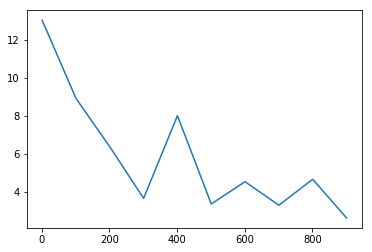

In [9]:
samples = []
l2_distances = []
for s in range(1, 1000, 100):
    posterior_dist = model.posterior_distribution(traces=s, observation=observation)
    l2_distance = float(F.pairwise_distance(posterior_dist.mean, posterior_mean_correct).sum())
    samples.append(s)
    l2_distances.append(l2_distance)
    
plt.plot(samples, l2_distances)

# Inference compilation

Inference compilation is a technique where a deep neural network is used for parameterizing the proposal distribution in importance sampling (https://arxiv.org/abs/1610.09900). This neural network, which we call inference network, is automatically generated and trained with data sampled from the model.

We can learn an inference network for our model.

In [10]:
model.learn_inference_network(observation=range(16), early_stop_traces=1000)

Creating new inference network...
Polymorphing, new layers for address: 6/forward_Categorical(length_categories:3)
Polymorphing, new layers for address: 42/forward.state_Categorical(length_categories:3)
Train. time | Trace     | Init. loss | Max. loss  | Min. loss  | Curr. loss | T.since min | Traces/sec
0d:00:00:22 | 1,024     | +1.882e+01 | +1.882e+01 | +1.553e+01 | +1.604e+01 | 0d:00:00:14 | 51                              
